I am sure by now you would have seen [Gemma 2's announcement](https://blog.google/technology/developers/google-gemma-2/) or [played around with the model](https://aistudio.google.com/app/prompts/new_chat?model=gemma-2-27b-it). If you haven't yet, I highly recommend that you do. 

![Comparison of Gemma 2 models on a variety of benchmarks](../images/gemma2-bench.png){#fig-1 fig-align="center" width=500}

Going by the benchmarks shared in the official Gemma 2 report, the model is extremely competitive and outperforming other models relative to it's size. 

![Evaluation of Gemma 2 9B and 27B Instruction Tuned models on the Chatbot Arena](../images/gemma2-chatarena.png){#fig-2 fig-align="center" width=500}


Also, as can be seen in @fig-2, the results from Chatbot arena for Gemma 2 models look pretty impressive, given the model sizes.

Below, I try to summarise **"Why is Gemma 2 such a big deal?"**:

- The model comes in **practical sizes** 3B, 9B & 27B that can fit on a single GPU (at the time of writing this blog post, the 3B version is yet to be released)
- Performance of the Gemma 2 models is on par with models twice or more it's size! 
- Model weights are open-source - thank you Google Deepmind!

As part of this blog post, we will be going deeper into some of the architectural components of Gemma 2 **along with their implementation in PyTorch**. Specifically we will be looking into:

1. *Grouped Query Attention* (@sec-gqa)
2. *Sliding Window Attention* (@sec-swa)
3. *Rotary Position Embeddings (RoPE)* (@sec-rope)
4. *Logit soft-capping* (@sec-logits)
5. *Model merging* (@sec-merge)

## Gemma 2 architectural details

In this section, we look into the architecture details as shared in the report - [Gemma 2: Improving Open Language Models at a Practical Size](https://storage.googleapis.com/deepmind-media/gemma/gemma-2-report.pdf).

From the report:

*In this work, we introduce Gemma 2, a new addition to the Gemma family of lightweight, state-of-the-art open models, ranging in scale from 2 billion to 27 billion parameters. The 9 billion and 27 billion parameter models are available today, with a 2 billion parameter model to be released shortly. In this new version, we provide several technical modifications to our architecture, such as interleaving local-global attentions (@longformer) and group-query attention (@gqa). We also train the 2B and 9B models with knowledge distillation (Hinton et al., 2015) instead of next token prediction. The resulting models deliver the best performance for their size, and even offer competitive alternatives to models that are 2-3× bigger.*

The recent large language models @llama3, have been known to have dataset sizes as big as 15T tokens! It is the longer training on bigger datasets that has been key towards LLMs having continued improvements in performance.  The models are trained to predict the next tokens in a left-to-right manner. 

In Gemma 2, the authors trained the smaller 2.6B and 9B models using knowledge distillation. This, alongside other architecture details, has allowed Gemma 2 to have the best in class performance given it's size. Let's look into each one of the components in the following sections.

## Group Query Attention {#sec-gqa}

Grouped query attention was introduced by @gqa in 2023. The key difference as compared to the standard Multi-headed attention has been highlighted in @fig-1.

In this part of the blog post, we understand more about Group Query Attention and implement in in PyTorch code from scratch.

For an introduction and in-depth understand to multi-head attention, I would like to refer the reader to my previous blog post on [Vision Transformer](https://amaarora.github.io/posts/2021-01-18-ViT.html) where we implement attention from scratch in PyTorch in [Section 8](https://amaarora.github.io/posts/2021-01-18-ViT.html#the-vision-transformer-in-pytorch).

![Group Query Attention Overview](../images/gqa.png){#fig-1 fig-align="center" width=500}

From the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper, attention mechanism was introduced using the formula: 

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$


In Grouped Query Attention, we reduce the number of key and value heads (thus, in a way, grouping heads together as shown in @fig-1). If the number of keys & value heads is reduced to 1, it is equivalent to Multi-Query Attention @mqa. 

Thus, Group Query Attention (GQA) is somewhere in the middle between MHA & MQA. Let's now implement it in PyTorch.

In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
from typing import Optional
import math
import torch.nn.functional as F

Having made the imports, let's define the model arguments. We assume that the input and output dimensions inside the Decoder layer are $4096$.

Below, the `n_kv_heads` defines the number of key & value heads. If the number is equal to 1, the below Attention implementation follows Multi-Query Attention. When the number is greater than 1 and less than `n_heads`, then we follow Group Query Attention as in @fig-1.

In [2]:
@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = 8
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5
    max_batch_size: int = 32
    max_seq_len: int = 2048

For our implementation, we assume 8 key & value heads whereas 32 query heads.

In [3]:
args = ModelArgs()
args

ModelArgs(dim=4096, n_layers=32, n_heads=32, n_kv_heads=8, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-05, max_batch_size=32, max_seq_len=2048)

Below, follows a standard implementation of Attention (without positional embeddings to keep it simple). We have our weight matrices for q,k & v layers defined as Linear layers. These weight matrices transform an input tensor $X$ to query $q$, key $k$ & value $v$ respectively. 

Taking in an input of shape $(2, 32, 4096)$ which represents a batch of 2 sequences of length 32, each represented by a 4096 long vector.

Upon taking the transform, given the weight matrices `self.wq`, `self.wk` & `self.wv`, the dimensions for our $q$, $k$ & $v$ matrices will be:

$q$ $->$ $(2, 32, 4096)$

$k$ $->$ $(2, 32, 1024)$

$v$ $->$ $(2, 32, 1024)$

In [4]:
class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        self.n_local_heads = args.n_heads
        self.n_local_kv_heads = self.n_kv_heads
        self.n_rep = self.n_local_heads // self.n_local_kv_heads
        self.head_dim = args.dim // args.n_heads
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False,)
        self.wk = nn.Linear(args.dim, args.n_kv_heads * self.head_dim, bias=False,)
        self.wv = nn.Linear(args.dim, args.n_kv_heads * self.head_dim, bias=False,)            
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False,)

    def forward(
        self,
        x: torch.Tensor,
    ):
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        # repeat k/v heads if n_kv_heads < n_heads
        xk = repeat_kv(xk, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)
        xv = repeat_kv(xv, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)

        xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        xk = xk.transpose(1, 2)
        xv = xv.transpose(1, 2)
        scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)

        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, xv)  # (bs, n_local_heads, seqlen, head_dim)
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)
        return self.wo(output)

The above implementation really follows @fig-1 very closely. First, we get the dimension per head `self.head_dim`, by simply doing `args.dim // args.n_heads`. Given the values, in this case, each head has a dimension of $128$.

Now, after the matrix multiplication with weight matrices, we do a reshape to get our $xq$, $xk$ & $xv$ values. 

Can you think what their dimensions would be?

In practice, we just repeat the $k$ & $v$ values, in this case `n_rep` is 4 to get $k$ and $v$ to have tensors of shape $[2, 32, 32, 128]$. We do this using the `repeat_kv` function below.

In [5]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

For a detailed explanation of this `repeat_kv` function, refer [here](https://github.com/meta-llama/llama/issues/384#issuecomment-1641359877). 

And that's really it. After that, we calculate our attention scores as usual, using the attention formula:


$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [6]:
X = torch.randn(2, 32, 4096)
attn = Attention(args)
attn(X).shape

torch.Size([2, 32, 4096])

And that's really all the magic that there is behind Group Query Attention (GQA)! You have just succesfully implemented it from scratch using PyTorch yourself!

## Sliding Window Attention {#sec-swa}

For a detailed explanation & implementation in PyTorch of Sliding Window Attention @longformer, I would like to refer the readers to my [previous blog post](https://amaarora.github.io/posts/2024-07-04%20SWA.html).

The authors interleaved local and global attentions in alternating layers, which helped reduce number of parameters (for compact model-size) while mantaining performance. This is pretty unique! From the paper:

*The sliding window size of local attention layers is set to 4096 tokens, while the span of the global attention layers is set to 8192 tokens.*

## Rotary Positional Embeddings (RoPE) {#sec-rope}

RoPE were introduced as part of the RoFormer architecture @roformer. From the paper itself:

*The proposed Rotary Position Embedding (RoPE) encodes the absolute position with a rotation matrix and meanwhile incorporates the explicit relative position dependency in self-attention formulation. Notably, RoPE enables valuable properties, including the flexibility of sequence length, decaying inter-token dependency with increasing relative distances, and the capability of equipping the linear self-attention with relative position encoding. We evaluate the enhanced transformer with rotary position embedding, also called RoFormer, on various long text classification benchmark datasets. Our experiments show that it consistently overcomes its alternatives.*

The Roformer has been integrated in the transformers library and can be used like so:
```python
from transformers import AutoTokenizer, RoFormerModel
import torch

tokenizer = AutoTokenizer.from_pretrained("junnyu/roformer_chinese_base")
model = RoFormerModel.from_pretrained("junnyu/roformer_chinese_base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
model(**inputs)
```

In [2]:
import torch.nn as nn 
import torch
from typing import Optional
import numpy as np

The below are the Positional Encodings from the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by @attention paper:

$$
PE_{(pos, 2i)} = \sin \left( \frac{pos}{10000^{\frac{2i}{d_{model}}}} \right)
$$

$$
PE_{(pos, 2i+1)} = \cos \left( \frac{pos}{10000^{\frac{2i}{d_{model}}}} \right)
$$

They work with absolute positions, but, not with relative positions. From Huggingface's implementation of the RoFormer architecture, this is how one could implement them in PyTorch code:

In [3]:
class RoFormerSinusoidalPositionalEmbedding(nn.Embedding):
    """This module produces sinusoidal positional embeddings of any length."""

    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None) -> None:
        super().__init__(num_positions, embedding_dim)
        self.weight = self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out: nn.Parameter) -> nn.Parameter:
        """
        Identical to the XLM create_sinusoidal_embeddings except features are not interleaved. The cos features are in
        the 2nd half of the vector. [dim // 2:]
        """
        n_pos, dim = out.shape
        position_enc = np.array(
            [[pos / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)] for pos in range(n_pos)]
        )
        out.requires_grad = False  # set early to avoid an error in pytorch-1.8+
        sentinel = dim // 2 if dim % 2 == 0 else (dim // 2) + 1
        out[:, 0:sentinel] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
        out[:, sentinel:] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
        out.detach_()
        return out

    @torch.no_grad()
    def forward(self, input_ids_shape: torch.Size, past_key_values_length: int = 0) -> torch.Tensor:
        """`input_ids_shape` is expected to be [bsz x seqlen]."""
        bsz, seq_len = input_ids_shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        )
        return super().forward(positions)


I don't go much into the detail of the implementation of `RoFormerSinusoidalPositionalEmbedding`, since it is pretty self-explanatory when we compare the implementation with the formula. 

There are some challenges to using absolute position encodings as above that I highlight below:

1. The self-attention architecture has shown to be position agnostic. Thus, by adding positional information to the context representation, it renders them unsuitable for the linear self-attention architecture. @yun2020
2. These encodings do-not follow the intuition that tokens close to each other should have more importance compared to tokens further away from each other. 
3. The sequences at test-time might be of different length to trainining-time, thus, leading to train-test discrepency. 

Thus, there is a need for positional encodings that overcome the above two challenges. From the RoPE paper:

*We introduce a novel method, namely Rotary Position Embedding(RoPE), to leverage the positional information into the learning process of PLMS. Specifically, RoPE encodes the absolute position with a rotation matrix and meanwhile incorporates the explicit relative position dependency in self-attention formulation. Note that the proposed RoPE is prioritized over the existing methods through valuable properties, including the sequence length flexibility, decaying inter-token dependency with increasing relative distances, and the capability of equipping the linear self-attention with relative position encoding.*

By utilising a derived rotation matrix, through RoPE, the authors were able to overcome the challenges and come up with a solution that not only solves the problem in theory but these embeddings are also easy to implement in practice! Thus, the widespread use of RoPE throughout multiple LLMs. 

Rotary Position Embeddings can be implemented easily using the following matrix multiplication, where 

$x_{i}$: contextual representation of token $x$ at position $i$. (`nn.Embedding`)

$$
R_{\Theta,m}^d x = \begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\vdots \\
x_{d-1} \\
x_d
\end{pmatrix} \otimes \begin{pmatrix}
\cos m\theta_1 \\
\cos m\theta_1 \\
\cos m\theta_2 \\
\cos m\theta_2 \\
\vdots \\
\cos m\theta_{d/2} \\
\cos m\theta_{d/2}
\end{pmatrix} + \begin{pmatrix}
-x_2 \\
x_1 \\
-x_4 \\
x_3 \\
\vdots \\
-x_d \\
x_{d-1}
\end{pmatrix} \otimes \begin{pmatrix}
\sin m\theta_1 \\
\sin m\theta_1 \\
\sin m\theta_2 \\
\sin m\theta_2 \\
\vdots \\
\sin m\theta_{d/2} \\
\sin m\theta_{d/2}
\end{pmatrix}
$${#eq-1}

We can get the sinusoidal and cosine values of the matrix multiplication from `RoFormerSinusoidalPositionalEmbedding`.

In [18]:
embedding_layer = RoFormerSinusoidalPositionalEmbedding(100, 64)
sinusoidal_pos = embedding_layer([1, 9])[None, None, :, :]
sinusoidal_pos.shape

torch.Size([1, 1, 9, 64])

Assuming 12 attention heads, each with a dimension of 64, we can randomly initialise our query and key layer like so:

In [19]:
query_layer = torch.randn(1, 12, 9, 64)
key_layer   = torch.randn(1, 12, 9, 64)
query_layer.shape, key_layer.shape

(torch.Size([1, 12, 9, 64]), torch.Size([1, 12, 9, 64]))

In [21]:
def apply_rotary_position_embeddings(sinusoidal_pos, query_layer, key_layer, value_layer=None):
    # https://kexue.fm/archives/8265
    # sin [batch_size, num_heads, sequence_length, embed_size_per_head//2]
    # cos [batch_size, num_heads, sequence_length, embed_size_per_head//2]
    sin, cos = sinusoidal_pos.chunk(2, dim=-1)
    # sin [θ0,θ1,θ2......θd/2-1] -> sin_pos [θ0,θ0,θ1,θ1,θ2,θ2......θd/2-1,θd/2-1]
    sin_pos = torch.stack([sin, sin], dim=-1).reshape_as(sinusoidal_pos)
    # cos [θ0,θ1,θ2......θd/2-1] -> cos_pos [θ0,θ0,θ1,θ1,θ2,θ2......θd/2-1,θd/2-1]
    cos_pos = torch.stack([cos, cos], dim=-1).reshape_as(sinusoidal_pos)
    # rotate_half_query_layer [-q1,q0,-q3,q2......,-qd-1,qd-2]
    rotate_half_query_layer = torch.stack([-query_layer[..., 1::2], query_layer[..., ::2]], dim=-1).reshape_as(
        query_layer
    )
    query_layer = query_layer * cos_pos + rotate_half_query_layer * sin_pos
    # rotate_half_key_layer [-k1,k0,-k3,k2......,-kd-1,kd-2]
    rotate_half_key_layer = torch.stack([-key_layer[..., 1::2], key_layer[..., ::2]], dim=-1).reshape_as(key_layer)
    key_layer = key_layer * cos_pos + rotate_half_key_layer * sin_pos
    if value_layer is not None:
        # rotate_half_value_layer [-v1,v0,-v3,v2......,-vd-1,vd-2]
        rotate_half_value_layer = torch.stack([-value_layer[..., 1::2], value_layer[..., ::2]], dim=-1).reshape_as(
            value_layer
        )
        value_layer = value_layer * cos_pos + rotate_half_value_layer * sin_pos
        return query_layer, key_layer, value_layer
    return query_layer, key_layer

Now, one could simply apply the rotary position embeddings using the above function `apply_rotary_position_embeddings`. Note that `rotate_half_query_layer` is just the following matrix: 

\begin{pmatrix}
-x_2 \\
x_1 \\
-x_4 \\
x_3 \\
\vdots \\
-x_d \\
x_{d-1}
\end{pmatrix}

Finally, by doing `query_layer = query_layer * cos_pos + rotate_half_query_layer * sin_pos`, we are replicating the matrix multiplication as in @eq-1.

In [25]:
query_layer, key_layer = apply_rotary_position_embeddings(sinusoidal_pos, query_layer, key_layer)
query_layer.shape, key_layer.shape

(torch.Size([1, 12, 9, 64]), torch.Size([1, 12, 9, 64]))

And that is all that there is to Rotary Position Embeddings. We have successfully re-implemented RoPE in PyTorch.

## Logit soft-capping{#sec-logits}

Another trick that was used by the authors of Gemma 2 was logit soft capping. Generally we use `torch.clip` or `torch.clamp` which is more like hard clipping. Instead the authors utilised soft-capping which can be formulated as:

$$\text{logits} \leftarrow \text{soft\_cap} * \tanh\left(\frac{\text{logits}}{\text{soft\_cap}}\right)$$



Let's have a look at the **tanh** function and plot it using `matplotlib`.

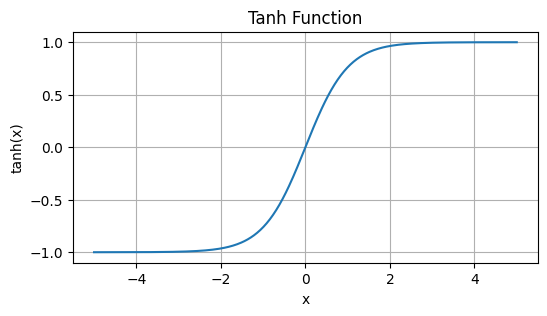

In [29]:
import numpy as np
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(6,3))

def plot_tanh():
    x = np.linspace(-5, 5, 400)
    y = np.tanh(x)
    plt.plot(x, y)
    plt.title('Tanh Function')
    plt.xlabel('x')
    plt.ylabel('tanh(x)')
    plt.grid(True)
    plt.show()

plot_tanh()

Looking at the `tanh` function, one can notice that it limits the upper and lower bounds between -1 & 1, with $+∞$ approaching 1, and $-∞$ approaching -1. It's pretty easy to implement logit soft capping in PyTorch.

```python
import torch

def soft_cap_logits(logits, soft_cap):
    scaled_logits = logits / soft_cap
    t = torch.tanh(scaled_logits)
    return soft_cap * t


logits = torch.tensor([0.5, 1.0, 2.0, 3.0])
soft_cap = 2.0
capped_logits = soft_cap_logits(logits, soft_cap)
```

The authors capped the attention logits at 50.0 and final logits at 30.0.

## Model merging {#sec-merge}

From the paper:

*Model merging. We average models from experiments run with different hyperparameters @warp .*

I would like to refer the readers to mergekit (@mergekit), which is an open-source library for merging pre-trained Large Language Models. 

From the [Gemma 2 introduction blog by Huggingface](https://huggingface.co/blog/gemma2#model-merging):

*According to the Technical Report, Gemma 2 used Warp, a new merging technique that merges models in three distinct stages:

- *Exponential Moving Average (EMA): This is applied during the reinforcement learning (RL) fine-tuning process.*
- *Spherical Linear intERPolation (SLERP): This is applied after the RL fine-tuning of multiple policies.*
- *Linear Interpolation Towards Initialization (LITI): This stage is applied after the SLERP stage.*

Please refer to [one of my previous blogs](https://wandb.ai/wandb_fc/pytorch-image-models/reports/Revisiting-ResNets-Improved-Training-and-Scaling-Strategies--Vmlldzo2NDE3NTM#ema-of-weights) for an in-depth explanation and implementation in PyTorch on **Exponential Moving Average**.

Going by the **mergekit** repository, merging models is as simple as running this one line of code:

`mergekit-yaml path/to/your/config.yml ./output-model-directory [--cuda] [--lazy-unpickle] [--allow-crimes] [... other options]`

## Conclusion 

As part of the following blog post we took a deep dive into grouped query qttention, sliding window attention, RoPE embeddings, logits soft-capping & also model-merging. 

We did it all with the motivation from Gemma 2. The idea was to dig deeper into the Gemma 2 architecture. I hope that through this blog post, the reader is able to understand more about the Gemma 2 architecture in detail. 

Thank you for your time!